# Random Forest Project Tutorial

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

from sklearn.metrics import mean_squared_error, r2_score

from pickle import dump

In [2]:
X_train = pd.read_csv('X_train_reduced.csv')
X_test = pd.read_csv('X_test_reduced.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

X_train.head()

,Glucose,BMI,BloodPressure,Age
0,84.0,0.0,0.0,21.0
1,112.0,28.2,82.0,50.0
2,139.0,28.7,46.0,22.0
3,161.0,21.9,50.0,65.0
4,134.0,46.2,80.0,46.0


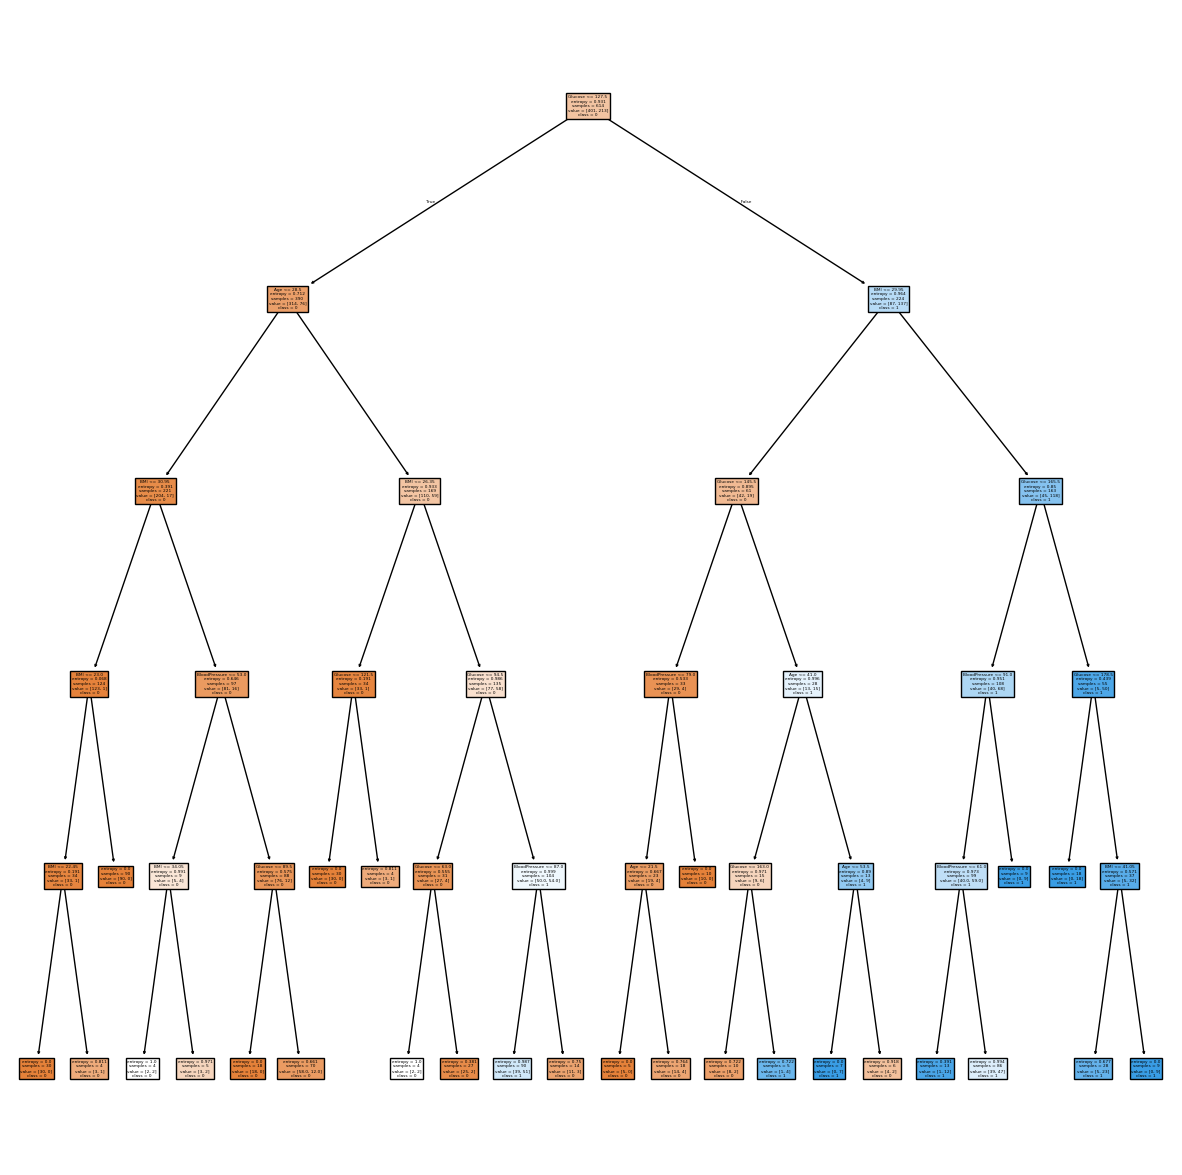


 
 Decision Tree Accuracy: 0.7142857142857143


In [3]:
# 10.A) Applying Decision Tree -again- to data set for Random Forest comparsion

# Training again the Decision Tree just with the selected features:

decision_tree_model = DecisionTreeClassifier(criterion =  "entropy", max_depth = 5, min_samples_leaf = 4, min_samples_split = 2, random_state=42)

decision_tree_model.fit(X_train, y_train)

# Visualize the tree

from sklearn import tree

fig = plt.figure(figsize=(15,15))

tree.plot_tree(decision_tree_model, feature_names = list(X_train.columns), class_names = ["0", "1"], filled = True)

plt.show()

# Test the Decision Tree just with the selected features:
y_pred = decision_tree_model.predict(X_test)
y_pred


# Evaluate the Decision Tree just with the selected features:

from sklearn.metrics import accuracy_score

decision_tree_accuracy = accuracy_score(y_test, y_pred)

print(f"\n \n Decision Tree Accuracy: {decision_tree_accuracy}")

dump(decision_tree_model, open("decision_tree_regressor_with_decision_tree_feature_selection_42.sav", "wb"))



In [ ]:
# 15) Random Forest Model 
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(random_state = 42)
random_forest_model.fit(X_train, y_train)
y_pred = random_forest_model.predict(X_test)
y_pred

random_forest_model_accuracy = accuracy_score(y_test, y_pred)
random_forest_model_accuracy

print(f"\n \n Random Forest Accuracy: {random_forest_model_accuracy}")
print(f"\n \n Decision Tree Accuracy: {decision_tree_accuracy}\n")


dump(random_forest_model_accuracy, open("random_forest_model_efault_42.sav", "wb"))



/home/vscode/.local/lib/python3.10/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



 
 Random Forest Accuracy: 0.7402597402597403

 
 Decision Tree Accuracy: 0.7142857142857143

